# Building a Trump Tweet Classifier with Keras

#### Author: Dr. James Allen-Robertson , Dept. of Sociology University of Essex UK

The data for this project can be obtained from https://github.com/bpb27/trump_tweet_data_archive - specifically you will need the condensed archive files for 2015, 2016 and 2017. Once downloaded ensure this notebook file and the archives are in the same folder, or adjust the paths accordingly.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.concat([pd.read_json('condensed_2016.json'), pd.read_json('condensed_2017.json'), pd.read_json('condensed_2015.json')])
# df.source = pd.Categorical(df.source)

In [3]:
df = df[~df.text.str.startswith('RT')]
df.reset_index(inplace=True)


In [4]:
df.set_index('created_at', inplace=True)
df.sort_index(inplace=True)


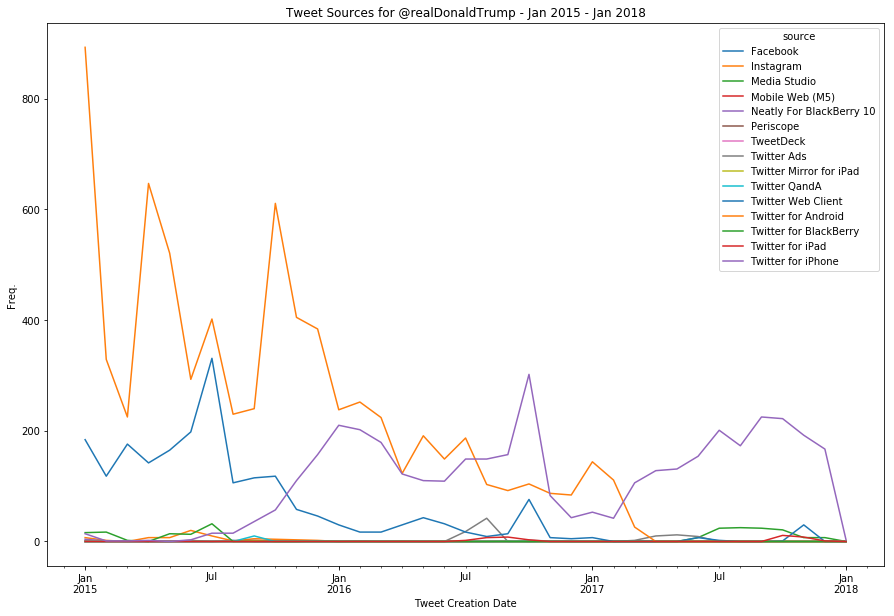

In [5]:
df.pivot_table(index='created_at',columns=['source'],values='index', aggfunc='count').resample('M').count().plot(figsize=(15,10), title='Tweet Sources for @realDonaldTrump - Jan 2015 - Jan 2018')
plt.xlabel('Tweet Creation Date')
plt.ylabel('Freq.')
plt.savefig('1_tweet_sources.png')

In [6]:
top3_sources = df.source.value_counts().index[:3].tolist()

In [7]:
top2_sources = ['Twitter for Android', 'Twitter for iPhone']

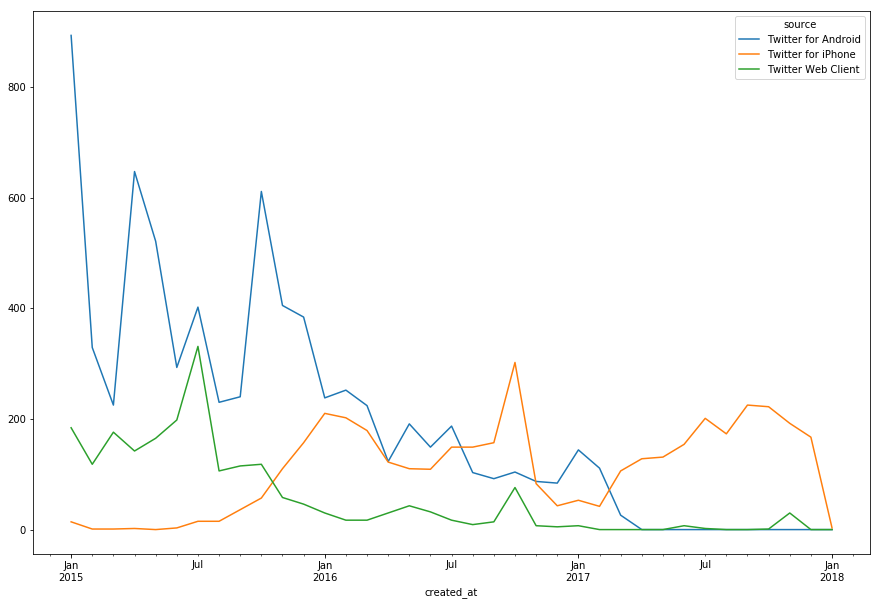

In [8]:
df.pivot_table(index='created_at',columns=['source'],values='index', aggfunc='count').loc[:,top3_sources].resample('M').count().plot(figsize=(15,10))

# Pre-Iphone

When did Trump switch to iPhone?

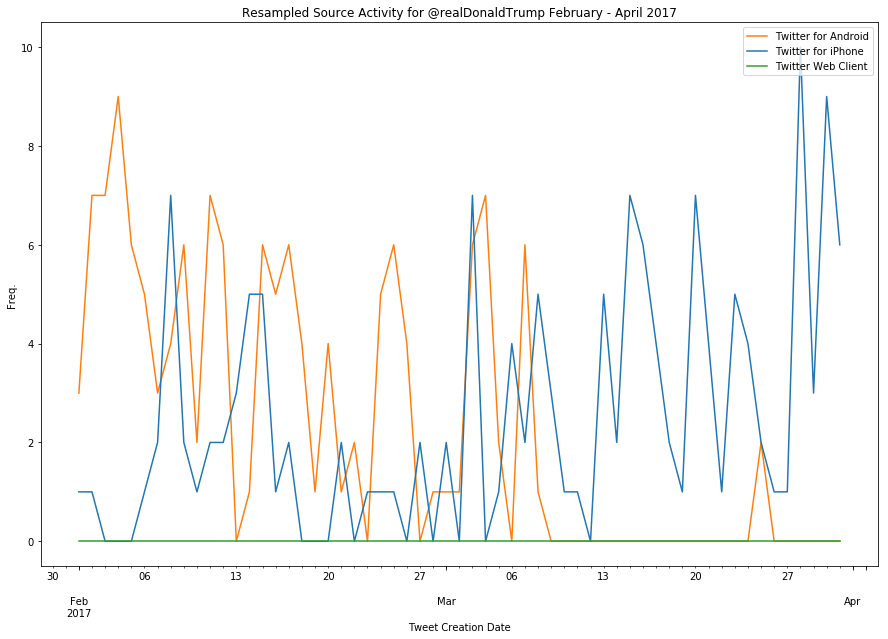

In [9]:
ax = df.pivot_table(index='created_at',columns=['source'],values='index', aggfunc='count').loc['February 2017':'March 2017',top3_sources].resample('D').count().plot(figsize=(15,10))


# Ensure that Android stays Orange
for ax in plt.gcf().axes:
    ax.get_lines()[1].set_color("#1f77b4")
    ax.get_lines()[0].set_color("#ff7f0e")
    ax.get_lines()[2].set_color("#2ca02c")

plt.legend(loc='upper right')
plt.title('Resampled Source Activity for @realDonaldTrump February - April 2017')
plt.xlabel('Tweet Creation Date')
plt.ylabel('Freq.')
plt.savefig('android_dark_date.png')

In [10]:
pre_iphone_data = df.loc['June 2015':'08 March 2017'].copy()

In [11]:
post_iphone_data = df.loc['09 March 2017':].copy()

# Training a Trump Classifier with Keras

In [12]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Fit a TFIDF Model to the Whole Corpus of Text

In [14]:
tfidf = TfidfVectorizer(max_df=0.95,min_df=0.02)

In [15]:
tfidf.fit(df.text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=0.02,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
n_cols = len(tfidf.get_feature_names())

In [17]:
def build_model(input_shape, output_shape, layers=2, nodes=100):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape = (input_shape,)))
    for x in range(layers):
        model.add(Dense(nodes, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','mean_squared_error'])
    return model

### Designate all Trump Tweets as Target 1, and all others as Target 0

In [19]:
pre_iphone_data['targets'] = pre_iphone_data.source.apply(lambda x: 1 if x == 'Twitter for Android' else 0)
post_iphone_data['targets'] = post_iphone_data.source.apply(lambda x: 1 if x == 'Twitter for Android' else 0)
pre_iphone_data.targets.value_counts()

1    4678
0    3801
Name: targets, dtype: int64

### Evaluate a variety of models for highest accuracy

The model evaluator uses Stratified K Fold to slice up the data into 10 sets of testing and training data. Each model of x layers and y nodes per layer is then tested with every set of training and testing data. Accuracy scores are aggregated for a mean score to evaluate the quality of that neural network model.

In [ ]:
early_stopping_monitor = EarlyStopping(patience=2,monitor='acc')

In [83]:
def model_evaluator(X, Y, layers=[1,2,3], nodes=[100,200,500], kfold_splits=10, add_to_scores=[], add_to_labels=[]):
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=1)
    top_score = 0
    idx=0
    for layer in layers:
        for node_num in nodes:
            sub_score = []
            
            for train, test in kfold.split(X, Y):
                model = build_model(n_cols, 2,nodes=node_num, layers=layer)
                model.fit(X[train],to_categorical(Y[train]), epochs=50, callbacks=[early_stopping_monitor],verbose=0)
                sub_score.append(model.evaluate(X[test], to_categorical(Y[test]))[1] *100)

            score = pd.np.mean(sub_score)
            score_name = model.metrics_names[1]

            print(f'{layer},{node_num} - {score_name}: {score.round(2)}%')
            
            add_to_labels.append(f'M{idx:02}-{layer},{node_num}')
            add_to_scores.append(score)
            idx += 1
            if score > top_score:
                print(f'{layer},{node_num} is the current top model!')
                top_score = score
    return add_to_scores, add_to_labels

In [80]:
layers = [1,2,3,4]
nodes = [500,1000,2000]

from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
X = tfidf.transform(pre_iphone_data.text).toarray()
Y = pd.np.array(pre_iphone_data.targets)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
score_history_scores = []
score_history_labels = []


In [22]:
import os
from sklearn.externals import joblib

if not os.path.exists('scores.pkl'):
    new_scores, new_labels = model_evaluator(X,Y, layers=layers, nodes=nodes,add_to_scores=score_history_scores, add_to_labels=score_history_labels)
    joblib.dump(new_scores,'scores.pkl')
    joblib.dump(new_labels,'labels.pkl')
else:
    new_scores = joblib.load('scores.pkl')
    new_labels = joblib.load('labels.pkl')

847/847 [==============================] - 0s 173us/step
1,500 - acc: 76.09%
1,500 is the current top model!
847/847 [==============================] - 0s 305us/step
1,1000 - acc: 74.95%
847/847 [==============================] - 0s 471us/step
1,2000 - acc: 75.48%
847/847 [==============================] - 1s 653us/step
2,500 - acc: 75.21%
847/847 [==============================] - 1s 872us/step
2,1000 - acc: 76.2%
2,1000 is the current top model!
847/847 [==============================] - 1s 1ms/step
2,2000 - acc: 75.43%
847/847 [==============================] - 1s 1ms/step
3,500 - acc: 75.68%
847/847 [==============================] - 1s 2ms/step
3,1000 - acc: 75.19%
847/847 [==============================] - 2s 2ms/step
3,2000 - acc: 75.81%
847/847 [==============================] - 2s 2ms/step
4,500 - acc: 75.79%
847/847 [==============================] - 2s 2ms/step
4,1000 - acc: 76.35%
4,1000 is the current top model!
847/847 [==============================] - 2s 3ms/step
4,2000

#### We then plot the average score of 10 different subsets of the data for each model.

In [87]:
data = pd.DataFrame([new_scores,new_labels], index=['scores','labels']).transpose()

In [139]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


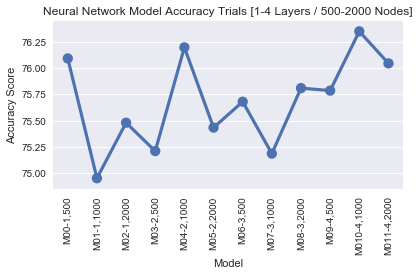

In [140]:
# plt.figure(figsize=(10,10))
sns.pointplot(data=data,x='labels',y='scores')
# sns.set_style('whitegrid')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Neural Network Model Accuracy Trials [1-4 Layers / 500-2000 Nodes]')
plt.savefig('accuracy_scores.jpg', dpi=400, )

4 Layers of 1000 Nodes is our top model though 2,1000 and even 1,500 provide similar accuracy

#### In this case of the three highest performing models we'll go for Model-04. It provides a little extra complexity than than Model-00 but less overhead than the top Model-011

In [99]:
train, test = train_test_split(pre_iphone_data, test_size=0.3)

In [103]:
final_model = build_model(layers=2, nodes=1000,input_shape=n_cols,output_shape=2)

In [104]:
final_model.fit(tfidf.transform(train.text),to_categorical(train.targets), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
5935/5935 [==============================] - 9s 2ms/step - loss: 0.4963 - acc: 0.7624 - mean_squared_error: 0.1639
Epoch 2/50
5935/5935 [==============================] - 3s 493us/step - loss: 0.4310 - acc: 0.8062 - mean_squared_error: 0.1384
Epoch 3/50
5935/5935 [==============================] - 3s 491us/step - loss: 0.3956 - acc: 0.8206 - mean_squared_error: 0.1262
Epoch 4/50
5935/5935 [==============================] - 3s 495us/step - loss: 0.3541 - acc: 0.8416 - mean_squared_error: 0.1119
Epoch 5/50
5935/5935 [==============================] - 3s 495us/step - loss: 0.3077 - acc: 0.8704 - mean_squared_error: 0.0955
Epoch 6/50
5935/5935 [==============================] - 3s 491us/step - loss: 0.2512 - acc: 0.8954 - mean_squared_error: 0.0764
Epoch 7/50
5935/5935 [==============================] - 3s 493us/step - loss: 0.1878 - acc: 0.9232 - mean_squared_error: 0.0561
Epoch 8/50
5935/5935 [==============================] - 3s 493us/step - loss: 0.1382 - acc: 0.9454 - mean_

In [105]:
final_model.evaluate(tfidf.transform(test.text), to_categorical(test.targets))

2544/2544 [==============================] - 3s 1ms/step


[1.3795394775627543, 0.7688679245283019, 0.20585478884431552]

#### Here we see the chosen top model, when given all the training data is ~76% accurate at identifying Trump Tweets

We feed the model the test data to provide further training before utilising it for prediction.

In [106]:
final_model.fit(tfidf.transform(test.text),y=to_categorical(test.targets),epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
2544/2544 [==============================] - 1s 508us/step - loss: 0.5755 - acc: 0.7622 - mean_squared_error: 0.1672
Epoch 2/50
2544/2544 [==============================] - 1s 492us/step - loss: 0.3929 - acc: 0.8211 - mean_squared_error: 0.1248
Epoch 3/50
2544/2544 [==============================] - 1s 491us/step - loss: 0.3341 - acc: 0.8471 - mean_squared_error: 0.1051
Epoch 4/50
2544/2544 [==============================] - 1s 493us/step - loss: 0.2713 - acc: 0.8781 - mean_squared_error: 0.0837
Epoch 5/50
2544/2544 [==============================] - 1s 492us/step - loss: 0.1786 - acc: 0.9308 - mean_squared_error: 0.0529
Epoch 6/50
2544/2544 [==============================] - 1s 492us/step - loss: 0.1170 - acc: 0.9552 - mean_squared_error: 0.0334
Epoch 7/50
2544/2544 [==============================] - 1s 494us/step - loss: 0.0560 - acc: 0.9811 - mean_squared_error: 0.0145
Epoch 8/50
2544/2544 [==============================] - 1s 492us/step - loss: 0.0314 - acc: 0.9921 - mea

In [107]:
final_model.evaluate(tfidf.transform(pre_iphone_data.text), to_categorical(pre_iphone_data.targets))

8479/8479 [==============================] - 2s 187us/step


[0.33951279843431037, 0.9234579548491019, 0.06481872498162912]

... and see it is 92% accurate, however this is on the data it has already seen so this measure cannot be taken as accuracy on unseen data. The 77% is much closer to the model's accuracy.

In [108]:
final_model.save('Trump_tweet_classifier.bin')

# Finding Trump

We make our predictions on the tweets after the iPhone was introduced... 

In [109]:
from keras.models import load_model

In [110]:
final_model = load_model('Trump_tweet_classifier.bin')

In [111]:
predictions = final_model.predict(tfidf.transform(post_iphone_data.text))

In [112]:
post_iphone_data['prediction'] = predictions.argmax(axis=1)

In [113]:
post_iphone_data['prediction_score'] = predictions.max(axis=1)

In [114]:
post_iphone_data.prediction.value_counts()

1    997
0    896
Name: prediction, dtype: int64

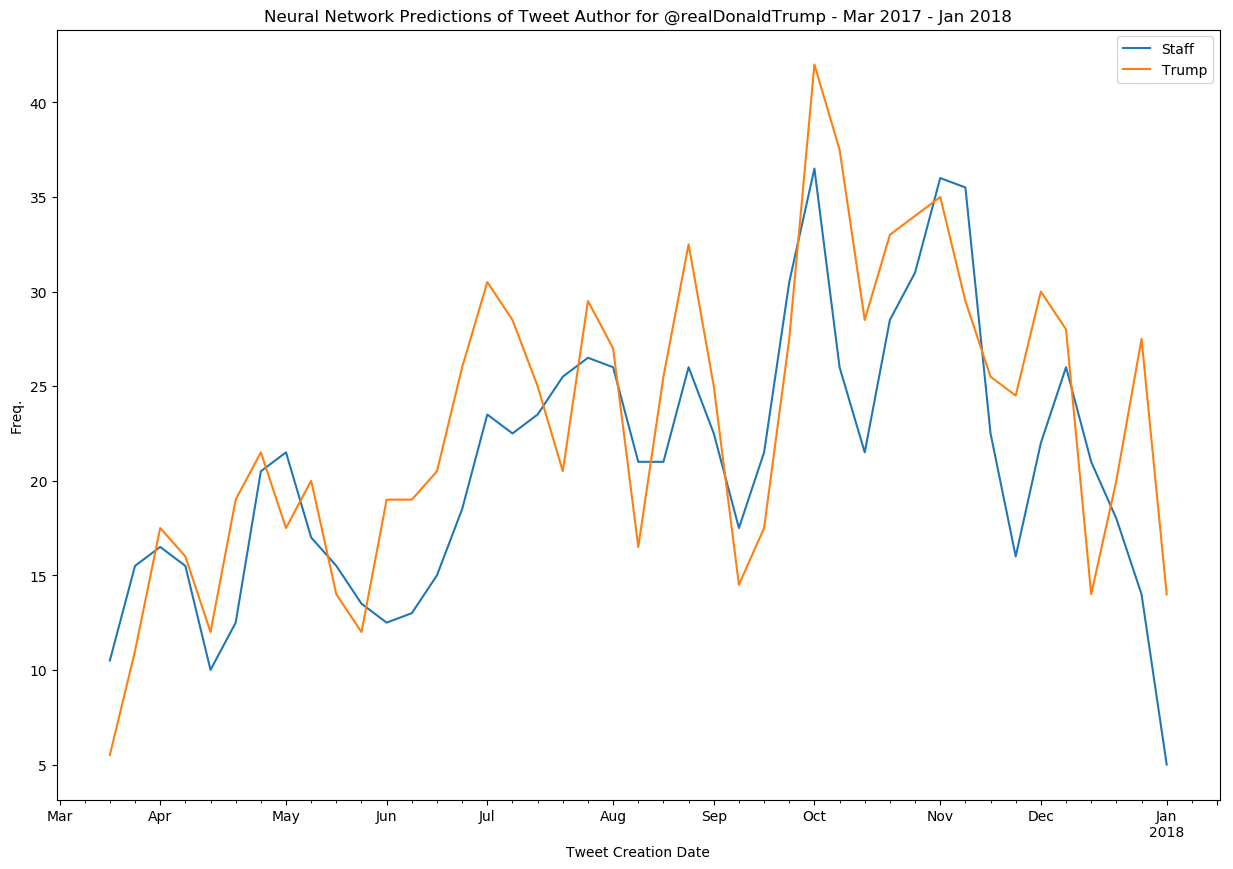

In [144]:
sns.reset_orig()
ax = post_iphone_data.pivot_table(index='created_at',columns=['prediction'],values='index', aggfunc='count').resample('W').count().rolling(2).mean().plot(figsize=(15,10))
ax.legend(['Staff', 'Trump'])
plt.xlabel('Tweet Creation Date')
plt.ylabel('Freq.')
plt.title('Neural Network Predictions of Tweet Author for @realDonaldTrump - Mar 2017 - Jan 2018')
plt.savefig('predictions.png', dpi=400)

... and it is now down to human evaluation to decide on how succesful the model is.

In [158]:
sample_trump_one = post_iphone_data[post_iphone_data.prediction == 1].sample(1)

sample_staff_one = post_iphone_data[post_iphone_data.prediction == 0].sample(1)
print('TRUMP')
print(f'Confidence: {sample_trump_one["prediction_score"].values[0]:.3f}%')
print(sample_trump_one['text'].values[0])
print()
print('STAFF')
print(f'Confidence: {sample_staff_one["prediction_score"].values[0]:.3f}%')
print(sample_staff_one['text'].values[0])

TRUMP
Confidence: 1.000%
The Russia-Trump collusion story is a total hoax, when will this taxpayer funded charade end?

STAFF
Confidence: 1.000%
In Nashville, Tennessee! Lets MAKE AMERICA GREAT AGAIN! https://t.co/m5UR4vv6UH


In [170]:
sample_trump = post_iphone_data[post_iphone_data.prediction == 1].sample(5)[['source','text','prediction_score']]
sample_staff = post_iphone_data[post_iphone_data.prediction == 0].sample(5)[['source','text','prediction_score']]

In [171]:
sample_trump.style.set_properties(subset=['text'], **{'width': '400'})


,source,text,prediction_score
created_at,,,
2017-10-11 01:21:43,Twitter for iPhone,"...fired. This story is totally made up by the dishonest media.The Chief is doing a FANTASTIC job for me and, more importantly, for the USA!",0.958198
2017-10-19 03:03:29,Twitter for iPhone,"""46% of Americans think the Media is inventing stories about Trump & his Administration."" @FoxNews It is actually much worse than this!",0.998146
2017-03-31 11:04:32,Twitter for iPhone,"Mike Flynn should ask for immunity in that this is a witch hunt (excuse for big election loss), by media & Dems, of historic proportion!",0.828915
2017-05-28 11:57:20,Twitter for iPhone,Big win in Montana for Republicans! We,0.999999
2017-06-04 11:43:30,Twitter for iPhone,Do you notice we are not having a gun debate right now? That's because they used knives and a truck!,0.999889


In [172]:
sample_staff.style.set_properties(subset=['text'], **{'width': '400'})

,source,text,prediction_score
created_at,,,
2017-03-28 15:26:23,Twitter for iPhone,The failing @NYTimes would do much better if they were honest! https://t.co/ATy8R3knS2,0.908425
2017-10-27 23:33:14,Twitter for iPad,Happy Birthday @TheLeeGreenwood! #FlashbackFriday https://t.co/MCrMK6Eurm,0.876031
2017-12-09 18:19:31,Twitter for iPhone,"It was my great honor to celebrate the opening of two extraordinary museums-the Mississippi State History Museum & the Mississippi Civil Rights Museum. We pay solemn tribute to our heroes of the past & dedicate ourselves to building a future of freedom, equality, justice & peace. https://t.co/5AkgVpV8aa",1
2017-06-21 01:42:59,Twitter for iPhone,It was a great honor to welcome President Petro Poroshenko of Ukraine to the @WhiteHouse today with @VP Pence. ➡️… https://t.co/J1ulOd6pYQ,0.99998
2017-08-17 02:55:18,Media Studio,THANK YOU @MayorGimenez for following the RULE OF LAW! Sanctuary cities make our country LESS SAFE! Full remarks: https://t.co/Kz2EsQ3f1v https://t.co/vD3BB3hyti,1
